In [ ]:
# useful links
# Betsy - https://stats.idre.ucla.edu/stata/seminars/regression-models-with-count-data/
# https://stats.idre.ucla.edu/r/dae/zinb/
# https://stats.idre.ucla.edu/stata/output/zero-inflated-negative-binomial-regression/
# https://towardsdatascience.com/an-illustrated-guide-to-the-zero-inflated-poisson-model-b22833343057
# https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

#https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html

In [139]:
from __future__ import print_function

# Import libraries
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from patsy import dmatrices

# For interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# turn off top and rigt axis line in matplotlib
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# change font size in matplolib
plt.rcParams.update({'font.size': 14})

# increasing the deafult DPI to improve resolution
#plt.rcParams['figure.dpi']= 50 # for preview
plt.rc("savefig", dpi = 300) # for saving

Naming convention for dataframes:

* sd - Secchi disk depth

* t - turbidity

* tss - total suspended solids

* c - chlorophyll

* tcc - total cell count

* tb - total biovolume

* ccc - cyano cell count

* cb - cyano biovolume

In [2]:
# Locate folder with csv for each variable
data_folder = "../../data/processed/regression/"
files = os.listdir(data_folder)

In [3]:
# Check CSV files in the folder
files

['chlorophyll_final.csv',
 'cyano_biovolume_final.csv',
 'cyano_cell_count_final.csv',
 'secchi_depth_final.csv',
 'total_biovolume_final.csv',
 'total_cell_count_final.csv',
 'total_suspended_solids_final.csv',
 'turbidity_final.csv',
 'tweets_daily_final.csv']

In [4]:
# Create a dictionary to hold all the dataframes
df = {}

# Name of dataframe indices - align with the order of files
names = ["c", "cb", "ccc", "sd", "tb", "tcc", "tss", "t", "tweets"]

In [5]:
# Import data
for name, file in zip(names, files):
        df[name] = pd.read_csv(f'{data_folder}{file}')

In [6]:
# Convert date column to datetime object
for file in df.keys():
    # seaprate if statement for tweets dataframe because its date column has a different name
    if file == "tweets":
        df[file]['time'] = pd.to_datetime(df[file]['time'])
    else:
        df[file]["OBJECTID_1"] = pd.to_datetime(df[file]["OBJECTID_1"])
        df[file].columns = df[file].columns.str.replace(".", "")
    

In [89]:
# Merge various tweet count stats with each dataframe

for file in df.keys():

    # Apply following steps in all the dataframes except the one for tweet counts per day
    if file != "tweets":
    
        # create new columns to store tweet counts data

        df[file]['tweets_neg_3_both'] = np.nan
        df[file]['tweets_pos_3_both'] = np.nan
        df[file]['tweets_wq_3_both']  = np.nan 

        df[file]['tweets_neg_3_before'] = np.nan
        df[file]['tweets_pos_3_before'] = np.nan
        df[file]['tweets_wq_3_before']  = np.nan 

        df[file]['tweets_neg_3_after'] = np.nan
        df[file]['tweets_pos_3_after'] = np.nan
        df[file]['tweets_wq_3_after']  = np.nan


        df[file]['tweets_neg_7_both'] = np.nan
        df[file]['tweets_pos_7_both'] = np.nan
        df[file]['tweets_wq_7_both']  = np.nan

        df[file]['tweets_neg_7_before'] = np.nan
        df[file]['tweets_pos_7_before'] = np.nan
        df[file]['tweets_wq_7_before']  = np.nan

        df[file]['tweets_neg_7_after'] = np.nan
        df[file]['tweets_pos_7_after'] = np.nan
        df[file]['tweets_wq_7_after']  = np.nan


        # Iterate over each row in wq variable
        for index, row in df[file].iterrows():

            # get dates for which we have water quality measurements
            date_wq = row['OBJECTID_1']

            # get index of the row with same date in the tweets data
            tweets_index = df["tweets"]['time'].eq(date_wq).idxmax()

            # get tweets info from 3 & 7 days before and after the date on which water quality was measured
            tweets_result_3_both = df["tweets"].iloc[tweets_index-3: tweets_index+4]
            tweets_result_3_before = df["tweets"].iloc[tweets_index-3: tweets_index+1]
            tweets_result_3_after = df["tweets"].iloc[tweets_index: tweets_index+4]

            tweets_result_7_both = df["tweets"].iloc[tweets_index-7: tweets_index+8]
            tweets_result_7_before = df["tweets"].iloc[tweets_index-7: tweets_index+1]
            tweets_result_7_after = df["tweets"].iloc[tweets_index: tweets_index+8]

            # assign the sum of negative tweets
            df[file].loc[index, 'tweets_neg_3_both'] = tweets_result_3_both['neg'].sum() 
            df[file].loc[index, 'tweets_pos_3_both'] = tweets_result_3_both['pos'].sum()
            df[file].loc[index, 'tweets_wq_3_both'] = tweets_result_3_both['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_3_before'] = tweets_result_3_before['neg'].sum() 
            df[file].loc[index, 'tweets_pos_3_before'] = tweets_result_3_before['pos'].sum()
            df[file].loc[index, 'tweets_wq_3_before'] = tweets_result_3_before['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_3_after'] = tweets_result_3_after['neg'].sum() 
            df[file].loc[index, 'tweets_pos_3_after'] = tweets_result_3_after['pos'].sum()
            df[file].loc[index, 'tweets_wq_3_after'] = tweets_result_3_after['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_7_both'] = tweets_result_7_both['neg'].sum() 
            df[file].loc[index, 'tweets_pos_7_both'] = tweets_result_7_both['pos'].sum()
            df[file].loc[index, 'tweets_wq_7_both'] = tweets_result_7_both['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_7_before'] = tweets_result_7_before['neg'].sum() 
            df[file].loc[index, 'tweets_pos_7_before'] = tweets_result_7_before['pos'].sum()
            df[file].loc[index, 'tweets_wq_7_before'] = tweets_result_7_before['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_7_after'] = tweets_result_7_after['neg'].sum() 
            df[file].loc[index, 'tweets_pos_7_after'] = tweets_result_7_after['pos'].sum()
            df[file].loc[index, 'tweets_wq_7_after'] = tweets_result_7_after['water quality?'].sum()


        #     print(date_wq)
        #     print(tweets_result)

In [90]:
df['c']

{'c':    OID OBJECTID_1    COUNT      AREA        MIN         MAX       RANGE  \
 0    0 2016-06-30  27254.0  0.036135  12.600169   44.398483   31.798314   
 1    1 2017-05-10  27254.0  0.036135   3.889101   65.859085   61.969984   
 2    2 2017-05-11  27254.0  0.036135   4.360165    4.839949    0.479784   
 3    3 2017-06-15  27254.0  0.036135   2.729604   76.986504   74.256899   
 4    4 2017-07-11  27254.0  0.036135  44.539921  250.619919  206.079998   
 5    5 2017-08-07  27254.0  0.036135   3.893605  257.613037  253.719432   
 6    6 2017-08-08  27254.0  0.036135   4.840908   17.092012   12.251104   
 7    7 2017-09-11  27254.0  0.036135   4.875043   83.855293   78.980250   
 8    8 2017-10-16  27254.0  0.036135   5.322431   25.637299   20.314868   
 9    9 2017-11-08  27254.0  0.036135   7.748047   24.199648   16.451601   
 10  10 2018-06-12  27254.0  0.036135   9.704348   53.198097   43.493750   
 11  11 2018-07-10  27254.0  0.036135  65.300514  379.298798  313.998283   
 12  12

# Statistical Analysis

Lets create functions to apply similar processes for all of our explanatory water qauality variables

In [86]:
# Creat histogram of tweet counts for all water quality variables to see if they are zero-inflated
# separate functions for 3 days and 7 days rolling windows
 
# 7 days rolling window
def histogram_7days(variable, plot_title):
    fig = plt.figure(figsize=(12,12))
    i = -1

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='lightskyblue', linewidth=1, edgecolor="white", bins=40)
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 7-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show() 
    
# 3 days rolling window
def histogram_3days(variable, plot_title):
    fig = plt.figure(figsize=(12,12))
    i = -10

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='pink', linewidth=1, edgecolor="white", bins=40)
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 3-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show()
    


In [176]:
# Perform poisson regresion
def poisson(wq, x, y):
    
    temp = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, temp, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p.summary()

#-----------------------------------------------------------------------

# Perform negative binomial
# following poisson results will feed into negative binomial
def poisson_for_nb(wq, x, y):
    
    temp = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, temp, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p, Y, X

def negative_binomial(wq, x, y):
    
    poisson_for_nb(wq, x, y)
    
    # Obtain rate vector from Poisson model
    temp2 = temp.copy()
    temp2['rate_lambda'] = model_p.mu
    
    # Auxiliary OLS regression to find α for the NB2 model
    # Calculate the dependent variable
    temp2['aux_ols_dependent'] = temp2.apply(lambda t: ((t[y] - t['rate_lambda'])**2 - t['rate_lambda']) / t['rate_lambda'], axis=1)
    
    # Using the α as dependent variable in an OLS regression model
    ols_formula = """aux_ols_dependent ~ rate_lambda - 1"""
    
    # Fitting the OLS regression model
    model_aux_olsr = smf.ols(ols_formula, temp2).fit()
    
    # The model coefficient is the alpha parameter for our negative binomial
    alpha = model_aux_olsr.params[0]
    
    # Get the associate t-value to determine significance
    t_value = model_aux_olsr.tvalues[0]
    
    # Caluclate degrees of freedom (number of observations - regression variables - dispersion variable)
    deg_freedom = len(temp2) - 1 - 1
    
    # Determine t critical value at 95% significance value
    t_critical = scipy.stats.t.ppf(q=1-.05,df=deg_freedom)
    
    # If the alpha is significant, negative binomial can be a better fit than poisson
    if (t_value > t_critical):
        print ("Alpha parameter of negative binomial regression is significant")
    else:
        print ("Alpha parameter of negative binomial regression is not significant")
        
    # Fit negative binomial regression model
    model_nb = sm.GLM(Y, X,family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    
    # Print model information
    
    
    return model_nb.summary()

#-------------------------------------------------------

# Perform zero inflated poisson regression (ZIP)
def zero_inflated_poisson(water_quality_parameter, alias, independent_var, dependent_var):
    
    display(alias)
    
    # Model formula
    formula = f"{dependent_var} ~ {independent_var}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    y, x = dmatrices(formula, water_quality_parameter, return_type='dataframe')
    
    # Fit the model
    model_zip = sm.ZeroInflatedPoisson(endog=y, exog=x, exog_infl=x, inflation='logit').fit(maxiter=500, method='bfgs') #Fit the model using maximum likelihood
    
    return model_zip.summary()

In [181]:
# Run either poisson or negative binmoial using widgets
def regression_choice (Model, wq, x, y):
    print(f"{Model} - {y}")
    if Model == "Negative Binomial":
        return negative_binomial(wq, x, y)
    elif Model == "Poisson":
        return poisson(wq, x, y)
    

In [199]:
# Create interactive UI to run the statistical model
def run_models(): #FOR NOW THIS WORKS WITH THE POISSON FUNCTION BELOW

    interact_manual(regression_choice, Model = [("Negative Binomial", 'Negative Binomial'), ("Poisson", 'Poisson')],
                    wq = [("Secchi disk depth", 'sd'), ("Chlorophyll a", 'c'), 
                                             ("Total suspended solids", 'tss'),("Turbidity", 't'),
                                             ("Phytoplankton cell count", 'tcc'), ("Phytoplankton biovolume", 'tb'),
                                             ("Cyanobacteria cell count", 'ccc'), ("Cyanobacteria biovolume", 'cb')],
                x = [("75th percentile", 'X75'),("Median", 'X50'),
                    ("Mean", 'MEAN'), ("25th percentile", 'X25')], 
                     
                 y = [("Negative tweet counts in 3 prior days", 'tweets_neg_3_before'),
                      ("Negative tweet counts in 3 following days", 'tweets_neg_3_after'),
                      ("Negative tweet counts in 3 days rolling window", 'tweets_neg_3_both'),
                      ("Negative tweet counts in 7 prior days", 'tweets_neg_7_before'),
                      ("Negative tweet counts in 7 following days", 'tweets_neg_7_after'),
                      ("Negative tweet counts in 7 days rolling window", 'tweets_neg_7_both'),
                      ("---------------------------------------------", ''),
                      ("Total tweet counts in 3 prior days", 'tweets_wq_3_before'),
                      ("Total tweet counts in 3 following days", 'tweets_wq_3_after'),
                      ("Total tweet counts in 3 days rolling window", 'tweets_wq_3_both'),
                      ("Total tweet counts in 7 prior days", 'tweets_wq_7_before'),
                      ("Total tweet counts in 7 following days", 'tweets_wq_7_after'),
                      ("Total tweet counts in 7 days rolling window", 'tweets_wq_7_both'),
                      ("---------------------------------------------", ''),
                      ("Positive tweet counts in 3 prior days", 'tweets_pos_3_before'),
                      ("Positive tweet counts in 3 following days", 'tweets_pos_3_after'),
                      ("Positive tweet counts in 3 days rolling window", 'tweets_pos_3_both'),
                      ("Positive tweet counts in 7 prior days", 'tweets_pos_7_before'),
                      ("Positive tweet counts in 7 following days", 'tweets_pos_7_after'),
                      ("Positive tweet counts in 7 days rolling window", 'tweets_pos_7_both'),
                                  ]);

## No matter what variable you choose, it is giving same output
## For some parameters zero-inflated poisson is not working...
## for same reason zero-inflated negative binomial wasn't working

# I. Secchi disk depth

## Tweet distributions

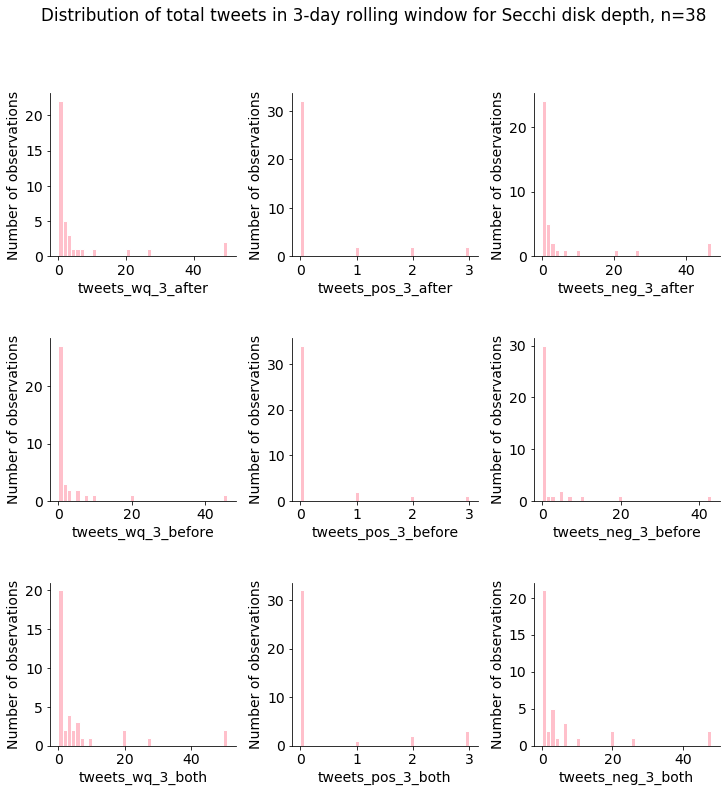

None

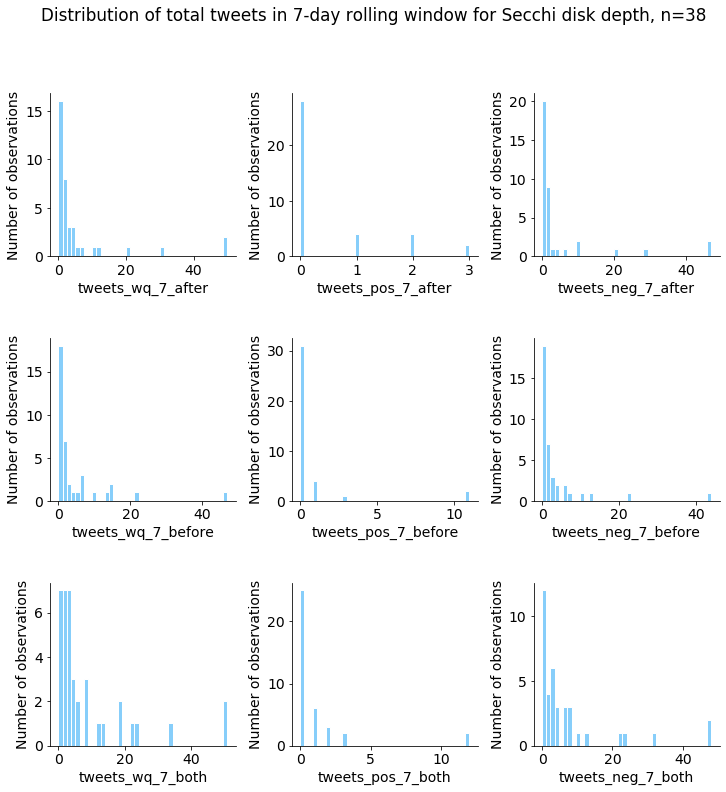

None

In [153]:
display(histogram_3days(df["sd"], "Secchi disk depth"));
display(histogram_7days(df["sd"], "Secchi disk depth"));

## Models - Negative Sentiment

In [184]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [185]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [186]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [187]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [188]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [189]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

## Models - Positive Sentiment

In [193]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [194]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [195]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [196]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [197]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [198]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

# II. Chlorophyll a - Corrected for pheophytin

In [200]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [201]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [186]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [187]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [188]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [189]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

## Models - Positive Sentiment

In [193]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [194]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [195]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [196]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [197]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [198]:
run_models()

interactive(children=(Dropdown(description='Model', options=(('Negative Binomial', 'Negative Binomial'), ('Poi…

In [ ]:
names = ["c", "cb", "ccc", "sd", "tb", "tcc", "tss", "t", "tweets"]

In [13]:
def poisson(wq, x, y):
    
    abc = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, abc, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p.summary()

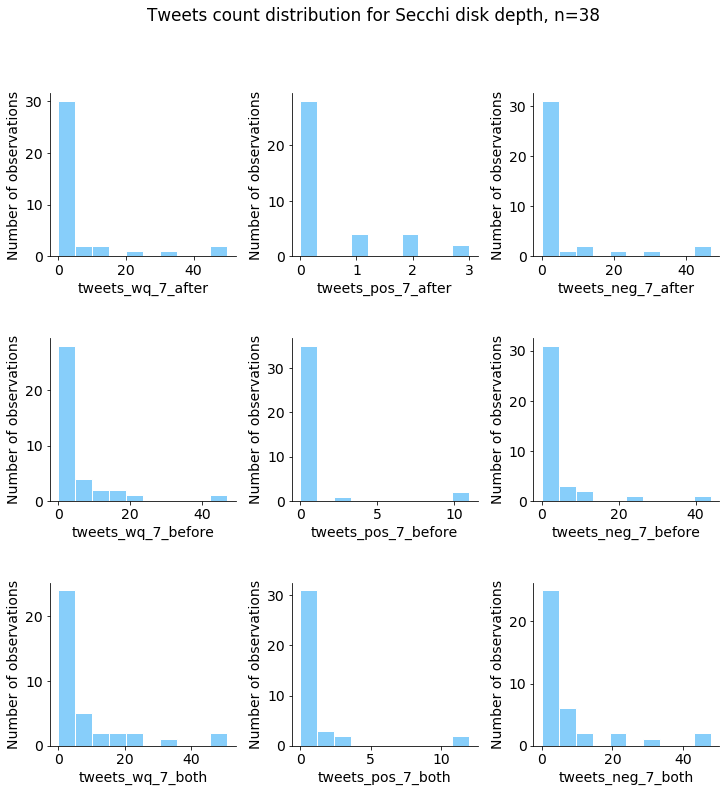

In [125]:
# Create histogram

fig = plt.figure(figsize=(12,12))
i = -1

for num in range(1,10):

    ax1 = fig.add_subplot(3,3,num)
    ax1.hist(sd.iloc[:,i], color='lightskyblue', linewidth=1, edgecolor="white")
    ax1.set(xlabel = sd.columns[i], ylabel=f'Number of observations')
    i-=1

fig.suptitle(f"Tweets count distribution for {Secchi disk depth}, n={len(sd)}")
#fig.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [ ]:
# Calculate mean and variance (NOPE DONT DO IT)
# Fit zero-inflated poisson regression
# Fit negative binomial regression and Zero-inflated binomial regression (see why? in below link)
# Create residual vs fitter plots for both

In [ ]:
# example of doing poisson and negative 
# https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/

# we might not always need zero inflated model
# https://statisticalhorizons.com/zero-inflated-models

In [140]:
df['sd']

,OID,OBJECTID_1,COUNT,AREA,MEAN,STD,SUM,X25.,X50.,X75.,...,tweets_wq_3_after,tweets_neg_7_both,tweets_pos_7_both,tweets_wq_7_both,tweets_neg_7_before,tweets_pos_7_before,tweets_wq_7_before,tweets_neg_7_after,tweets_pos_7_after,tweets_wq_7_after
0,0,2016-04-20,27254.0,0.036135,0.326584,6.522402e-02,8900.717586,0.292608,0.326837,0.379791,...,1.0,3.0,1.0,4.0,2.0,1.0,3.0,1.0,0.0,1.0
1,1,2016-05-25,27254.0,0.036135,0.200000,0.000000e+00,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0
2,2,2016-06-30,27254.0,0.036135,0.200000,0.000000e+00,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0
3,3,2017-05-10,27254.0,0.036135,0.266793,1.052118e-02,7271.177156,0.256585,0.267754,0.272464,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0
4,4,2017-05-11,27254.0,0.036135,0.271572,1.186248e-02,7401.413938,0.265434,0.269956,0.278423,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0
5,5,2017-06-15,27254.0,0.036135,0.321752,4.414198e-02,8769.025205,0.300185,0.308336,0.364803,...,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0
6,6,2017-07-11,27254.0,0.036135,0.214709,3.412158e-02,5851.680627,0.201629,0.212833,0.237013,...,27.0,32.0,0.0,34.0,3.0,0.0,5.0,29.0,0.0,30.0
7,7,2017-08-07,27254.0,0.036135,0.289606,3.882226e-02,7892.927859,0.274076,0.288600,0.306758,...,3.0,6.0,12.0,19.0,4.0,11.0,15.0,2.0,2.0,5.0
8,8,2017-08-08,27254.0,0.036135,0.265372,3.149683e-02,7232.436012,0.249463,0.263379,0.284706,...,4.0,6.0,12.0,19.0,4.0,11.0,15.0,2.0,1.0,4.0
9,9,2017-09-11,27254.0,0.036135,0.290509,3.197386e-02,7917.524259,0.275228,0.296750,0.305719,...,1.0,3.0,0.0,3.0,1.0,0.0,1.0,2.0,0.0,2.0


In [15]:
# Import explanatory and response variables data
tweets = pd.read_csv("../../data/processed/regression/tweets_daily_final.csv")
sd = pd.read_csv("../../data/processed/regression/secchi_depth_final.csv")
t = pd.read_csv("../../data/processed/regression/turbidity_final.csv")
tss = pd.read_csv("../../data/processed/regression/total_suspended_solids_final.csv")
c = pd.read_csv("../../data/processed/regression/chlorophyll_final.csv")
tcc = pd.read_csv("../../data/processed/regression/total_cell_count_final.csv")
tb = pd.read_csv("../../data/processed/regression/total_biovolume_final.csv")
ccc = pd.read_csv("../../data/processed/regression/cyano_cell_count_final.csv")
cb = pd.read_csv("../../data/processed/regression/cyano_biovolume_final.csv")


In [16]:
# convert date column to datetime object
tweets['time'] = pd.to_datetime(tweets['time'])
sd['OBJECTID_1'] = pd.to_datetime(sd['OBJECTID_1'])
t['OBJECTID_1'] = pd.to_datetime(t['OBJECTID_1'])
tss['OBJECTID_1'] = pd.to_datetime(tss['OBJECTID_1'])
c['OBJECTID_1'] = pd.to_datetime(c['OBJECTID_1'])
tcc['OBJECTID_1'] = pd.to_datetime(tcc['OBJECTID_1'])
tb['OBJECTID_1'] = pd.to_datetime(tb['OBJECTID_1'])
ccc['OBJECTID_1'] = pd.to_datetime(ccc['OBJECTID_1'])
cb['OBJECTID_1'] = pd.to_datetime(cb['OBJECTID_1'])

In [17]:
sd['OBJECTID_1'] = pd.to_datetime(sd['OBJECTID_1'])

In [18]:
sd['OBJECTID_1'][0] 

Timestamp('2016-04-20 00:00:00')

In [19]:
idx = tweets['time'].eq(sd['OBJECTID_1'][0]).idxmax()
res = tweets.iloc[idx-7: idx+1]

print(res)

          time  water quality?  neg  pos
103 2016-04-13             0.0  0.0  0.0
104 2016-04-14             3.0  2.0  1.0
105 2016-04-15             0.0  0.0  0.0
106 2016-04-16             0.0  0.0  0.0
107 2016-04-17             0.0  0.0  0.0
108 2016-04-18             0.0  0.0  0.0
109 2016-04-19             0.0  0.0  0.0
110 2016-04-20             0.0  0.0  0.0


In [20]:
# create new columns to store tweet counts data

sd['tweets_neg_3_both'] = np.nan
sd['tweets_pos_3_both'] = np.nan
sd['tweets_wq_3_both']  = np.nan 

sd['tweets_neg_3_before'] = np.nan
sd['tweets_pos_3_before'] = np.nan
sd['tweets_wq_3_before']  = np.nan 

sd['tweets_neg_3_after'] = np.nan
sd['tweets_pos_3_after'] = np.nan
sd['tweets_wq_3_after']  = np.nan


sd['tweets_neg_7_both'] = np.nan
sd['tweets_pos_7_both'] = np.nan
sd['tweets_wq_7_both']  = np.nan

sd['tweets_neg_7_before'] = np.nan
sd['tweets_pos_7_before'] = np.nan
sd['tweets_wq_7_before']  = np.nan

sd['tweets_neg_7_after'] = np.nan
sd['tweets_pos_7_after'] = np.nan
sd['tweets_wq_7_after']  = np.nan


# Iterate over each row in wq variable
for index, row in sd.iterrows():
    
    # get dates for which we have water quality measurements
    date_wq = row['OBJECTID_1']
    
    # get index of the row with same date in the tweets data
    tweets_index = tweets['time'].eq(date_wq).idxmax()
    
    # get tweets info from 3 & 7 days before and after the date on which water quality was measured
    tweets_result_3_both = tweets.iloc[tweets_index-3: tweets_index+4]
    tweets_result_3_before = tweets.iloc[tweets_index-3: tweets_index+1]
    tweets_result_3_after = tweets.iloc[tweets_index: tweets_index+4]
    
    tweets_result_7_both = tweets.iloc[tweets_index-7: tweets_index+8]
    tweets_result_7_before = tweets.iloc[tweets_index-7: tweets_index+1]
    tweets_result_7_after = tweets.iloc[tweets_index: tweets_index+8]
    
    # assign the sum of negative tweets
    sd.loc[index, 'tweets_neg_3_both'] = tweets_result_3_both['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_both'] = tweets_result_3_both['pos'].sum()
    sd.loc[index, 'tweets_wq_3_both'] = tweets_result_3_both['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_3_before'] = tweets_result_3_before['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_before'] = tweets_result_3_before['pos'].sum()
    sd.loc[index, 'tweets_wq_3_before'] = tweets_result_3_before['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_3_after'] = tweets_result_3_after['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_after'] = tweets_result_3_after['pos'].sum()
    sd.loc[index, 'tweets_wq_3_after'] = tweets_result_3_after['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_both'] = tweets_result_7_both['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_both'] = tweets_result_7_both['pos'].sum()
    sd.loc[index, 'tweets_wq_7_both'] = tweets_result_7_both['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_before'] = tweets_result_7_before['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_before'] = tweets_result_7_before['pos'].sum()
    sd.loc[index, 'tweets_wq_7_before'] = tweets_result_7_before['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_after'] = tweets_result_7_after['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_after'] = tweets_result_7_after['pos'].sum()
    sd.loc[index, 'tweets_wq_7_after'] = tweets_result_7_after['water quality?'].sum()
    
    
#     print(date_wq)
#     print(tweets_result)

In [21]:
sd.head(50)

,OID,OBJECTID_1,COUNT,AREA,MEAN,STD,SUM,X25.,X50.,X75.,...,tweets_wq_3_after,tweets_neg_7_both,tweets_pos_7_both,tweets_wq_7_both,tweets_neg_7_before,tweets_pos_7_before,tweets_wq_7_before,tweets_neg_7_after,tweets_pos_7_after,tweets_wq_7_after
0,0,2016-04-20,27254.0,0.036135,0.326584,6.522402e-02,8900.717586,0.292608,0.326837,0.379791,...,1.0,3.0,1.0,4.0,2.0,1.0,3.0,1.0,0.0,1.0
1,1,2016-05-25,27254.0,0.036135,0.200000,0.000000e+00,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0
2,2,2016-06-30,27254.0,0.036135,0.200000,0.000000e+00,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0
3,3,2017-05-10,27254.0,0.036135,0.266793,1.052118e-02,7271.177156,0.256585,0.267754,0.272464,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0
4,4,2017-05-11,27254.0,0.036135,0.271572,1.186248e-02,7401.413938,0.265434,0.269956,0.278423,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0
5,5,2017-06-15,27254.0,0.036135,0.321752,4.414198e-02,8769.025205,0.300185,0.308336,0.364803,...,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0
6,6,2017-07-11,27254.0,0.036135,0.214709,3.412158e-02,5851.680627,0.201629,0.212833,0.237013,...,27.0,32.0,0.0,34.0,3.0,0.0,5.0,29.0,0.0,30.0
7,7,2017-08-07,27254.0,0.036135,0.289606,3.882226e-02,7892.927859,0.274076,0.288600,0.306758,...,3.0,6.0,12.0,19.0,4.0,11.0,15.0,2.0,2.0,5.0
8,8,2017-08-08,27254.0,0.036135,0.265372,3.149683e-02,7232.436012,0.249463,0.263379,0.284706,...,4.0,6.0,12.0,19.0,4.0,11.0,15.0,2.0,1.0,4.0
9,9,2017-09-11,27254.0,0.036135,0.290509,3.197386e-02,7917.524259,0.275228,0.296750,0.305719,...,1.0,3.0,0.0,3.0,1.0,0.0,1.0,2.0,0.0,2.0


In [22]:
sd.columns = sd.columns.str.replace(".", "")

In [26]:
# Regression - Zero inflated poisson regression (zip)
formula = "tweets_neg_3_both ~ X75"

# Use Patsy package to carve out the X and y matrices for ZIP model 
y, x = dmatrices(formula, sd, return_type='dataframe')

In [27]:
# https://towardsdatascience.com/an-illustrated-guide-to-the-zero-inflated-poisson-model-b22833343057
model_zip = sm.ZeroInflatedPoisson(endog=y, exog=x, exog_infl=x, inflation='logit').fit(method='newton') #Fit the model using maximum likelihood
model_zip.summary()

Optimization terminated successfully.
         Current function value: 4.812086
         Iterations 9


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:       tweets_neg_3_both   No. Observations:                   38
Model:             ZeroInflatedPoisson   Df Residuals:                       36
Method:                            MLE   Df Model:                            1
Date:                 Wed, 03 Feb 2021   Pseudo R-squ.:                  0.2094
Time:                         15:49:32   Log-Likelihood:                -182.86
converged:                        True   LL-Null:                       -231.30
Covariance Type:             nonrobust   LLR p-value:                 7.359e-23
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_Intercept     0.2104      0.851      0.247      0.805      -1.458       1.879
inflate_X75          -2.8514      3.047     -0.936      0.349      -8.823       3.120
Intercept             3.7626      0.177     21.198      0.000       3.415       4.110
X75                  -6.4826      0.804     -8.068      0.000      -8.057      -4.908
=====================================================================================
"""

In [45]:
model.params

inflate_Intercept    0.142571
inflate_X75         -1.821641
Intercept            3.762716
X75                 -6.483317
dtype: float64

In [43]:
# Regression - Zero Inflated Negative Binomial
# explantion abt zero inflation https://stats.stackexchange.com/questions/77745/zero-inflated-negative-binomial/257900
model_zinb = sm.ZeroInflatedNegativeBinomialP(endog=y, exog=x, exog_infl=x, inflation='logit').fit(method='ncg')
model_zinb.summary()

Optimization terminated successfully.
         Current function value: 2.485412
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 25
         Hessian evaluations: 12


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3003: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3004: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                 tweets_neg_3_both   No. Observations:                   38
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       36
Method:                                      MLE   Df Model:                            1
Date:                           Wed, 03 Feb 2021   Pseudo R-squ.:                 0.01649
Time:                                   16:08:47   Log-Likelihood:                -94.446
converged:                                  True   LL-Null:                       -96.029
Covariance Type:                       nonrobust   LLR p-value:                   0.07515
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_Intercept    -1.5632      4.088     -0.382      0.702      -9.575       6.449
inflate_X75          -3.6975      8.550     -0.432      0.665     -20.454      13.059
Intercept             2.6209      0.620      4.229      0.000       1.406       3.836
X75                  -3.3416      1.589     -2.103      0.035      -6.456      -0.227
alpha                 2.5251      1.525      1.655      0.098      -0.465       5.515
=====================================================================================
"""

In [91]:
sd.head()

,OID,OBJECTID_1,COUNT,AREA,MEAN,STD,SUM,X25,X50,X75,...,tweets_wq_3_after,tweets_neg_7_both,tweets_pos_7_both,tweets_wq_7_both,tweets_neg_7_before,tweets_pos_7_before,tweets_wq_7_before,tweets_neg_7_after,tweets_pos_7_after,tweets_wq_7_after
0,0,2016-04-20,27254.0,0.036135,0.326584,0.065224,8900.717586,0.292608,0.326837,0.379791,...,1.0,3.0,1.0,4.0,2.0,1.0,3.0,1.0,0.0,1.0
1,1,2016-05-25,27254.0,0.036135,0.200000,0.000000,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0
2,2,2016-06-30,27254.0,0.036135,0.200000,0.000000,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0
3,3,2017-05-10,27254.0,0.036135,0.266793,0.010521,7271.177156,0.256585,0.267754,0.272464,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0
4,4,2017-05-11,27254.0,0.036135,0.271572,0.011862,7401.413938,0.265434,0.269956,0.278423,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0


In [95]:
# Negative Binomial
model_p = sm.GLM(y, x, family=sm.families.Poisson()).fit()
model_p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      tweets_neg_3_both   No. Observations:                   38
Model:                            GLM   Df Residuals:                       36
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -260.25
Date:                Thu, 04 Feb 2021   Deviance:                       441.59
Time:                        15:21:33   Pearson chi2:                     720.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5721      0.204     17.550      0.000       3.173       3.971
X75           -7.7967      0.935     -8.341      0.000      -9.629      -5.965
==============================================================================
"""

In [96]:
print(model_p.mu)
print(len(model_p.mu))

[ 1.84218021  7.48376053  7.48376053  4.25354061  4.06044186  2.07053739
  5.60776717  3.25558303  3.86631463  3.28207154  5.82362738  7.61787628
  5.23431776  7.43097574 16.32029085  6.6998727  12.55963451  5.11937474
  8.50120627  3.43171999  9.66553913  8.08956814  7.48376053  6.07489431
 11.25345059  2.84635143  0.04541661  1.2600313   0.11286375  1.71446446
  3.31094938  3.69373135  4.30936939  7.4837607   1.83918527  5.06775824
 16.32029104  7.4837607 ]
38


In [101]:
sd_copy = sd.copy()
sd_copy['BB_LAMBDA'] = model_p.mu

In [102]:
sd_copy['AUX_OLS_DEP'] = sd_copy.apply(lambda x: ((x['tweets_neg_3_both'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)

In [103]:
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

In [106]:
aux_olsr_results = smf.ols(ols_expr, sd_copy).fit()

In [112]:
print(aux_olsr_results.params)

BB_LAMBDA    2.166812
dtype: float64


In [108]:
aux_olsr_results.tvalues #seeing the significant t-value for 95 percentile it is significant

BB_LAMBDA    1.945057
dtype: float64

In [109]:
nb2_training_results = sm.GLM(y, x,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [110]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      tweets_neg_3_both   No. Observations:                   38
Model:                            GLM   Df Residuals:                       36
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -95.137
Date:                Thu, 04 Feb 2021   Deviance:                       48.908
Time:                        15:34:49   Pearson chi2:                     45.7
No. Iterations:                    34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5311      0.573      4.416      0.0

In [119]:
wq='sd'
x='X75'
y='tweets_neg_3_both'

In [136]:
temp = df[wq]
formula = f"{y} ~ {x}"
Y, X = dmatrices(formula, temp, return_type='dataframe')
model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
temp2 = temp.copy()
temp2['rate_lambda'] = model_p.mu
temp2['aux_ols_dependent'] = temp2.apply(lambda t: ((t[y] - t['rate_lambda'])**2 - t['rate_lambda']) / t['rate_lambda'], axis=1)
ols_formula = """aux_ols_dependent ~ rate_lambda - 1"""

model_aux_olsr = smf.ols(ols_formula, temp2).fit()

In [153]:
def poisson(wq, x, y):
    
    temp = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, temp, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p, Y, X

In [154]:
def negative_binomial(wq, x, y):
    
    poisson(wq, x, y)
    
#     temp = df[wq]
    
#     # Model formula
#     formula = f"{y} ~ {x}"
    
#     # Use Patsy package to carve out the x and y matrices for the ZIP model 
#     Y, X = dmatrices(formula, temp, return_type='dataframe')
    
#     # Fit the model
#     model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    # Obtain rate vector from Poisson model
    temp2 = temp.copy()
    temp2['rate_lambda'] = model_p.mu
    
    # Auxiliary OLS regression to find α for the NB2 model
    # Calculate the dependent variable
    temp2['aux_ols_dependent'] = temp2.apply(lambda t: ((t[y] - t['rate_lambda'])**2 - t['rate_lambda']) / t['rate_lambda'], axis=1)
    
    # Using the α as dependent variable in an OLS regression model
    ols_formula = """aux_ols_dependent ~ rate_lambda - 1"""
    
    # Fitting the OLS regression model
    model_aux_olsr = smf.ols(ols_formula, temp2).fit()
    
    # The model coefficient is the alpha parameter for our negative binomial
    alpha = model_aux_olsr.params[0]
    
    # Get the associate t-value to determine significance
    t_value = model_aux_olsr.tvalues[0]
    
    # Caluclate degrees of freedom (number of observations - regression variables - dispersion variable)
    deg_freedom = len(temp2) - 1 - 1
    
    # Determine t critical value at 95% significance value
    t_critical = scipy.stats.t.ppf(q=1-.05,df=deg_freedom)
    
    # If the alpha is significant, negative binomial can be a better fit than poisson
    if (t_value > t_critical):
        print ("Alpha parameter of negative binomial regression is significant")
    else:
        print ("Alpha parameter of negative binomial regression is not significant")
        
    # Fit negative binomial regression model
    model_nb = sm.GLM(Y, X,family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    
    return model_nb.summary()

In [155]:
negative_binomial('sd', 'X75', 'tweets_neg_3_both')

Alpha parameter of negative binomial regression is significant


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      tweets_neg_3_both   No. Observations:                   38
Model:                            GLM   Df Residuals:                       36
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -95.137
Date:                Thu, 04 Feb 2021   Deviance:                       48.908
Time:                        16:35:42   Pearson chi2:                     45.7
No. Iterations:                    34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5311      0.573      4.416      0.000       1.408       3.654
X75           -3.3140      1.924     -1.723      0.085      -7.084       0.456
==============================================================================
"""

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



In [154]:
def f(x):
    return x
interact(f, x=[('oneeeeeeeeeeeeeeeeeeeeffffffffffddddddddddddddddddddddddd', '10'), ('two', 20)]);

interactive(children=(Dropdown(description='x', options=(('oneeeeeeeeeeeeeeeeeeeeffffffffffddddddddddddddddddd…